# MEarl data

Generator for this dataset is taken from the project:
https://github.com/matthewearl/deep-anpr

In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

DATA_PATH = '../data/mearl/'

## Import data

Data is stored in csv file. Images are saved as PNG files.

Data will be loaded into the following variables:
  * X - Images, (num_of_images, image_height, image_width) Tensor
  * Y - Labels, (num_of_images, 4) left, top, right, bottom 

In [8]:
def load_image(fname):
    return io.imread(DATA_PATH + fname) / 256.

df = pd.read_csv(DATA_PATH + 'train.csv')
img = load_image(df.iloc[0].image)
print('Image dimension: ' + str(img.shape))
df.head()

Image dimension: (64, 128)


,image,plate,left,top,right,bottom
0,00000000_XQ64ETF.png,XQ64ETF,10,5,52,17
1,00000001_OD68CEP.png,OD68CEP,3,26,50,38
2,00000002_TI06CXJ.png,TI06CXJ,40,21,80,32
3,00000003_LL88RGF.png,LL88RGF,23,26,79,38
4,00000004_MD56HBW.png,MD56HBW,36,26,80,38


Basic image information

In [17]:
xs = [load_image(fname) for fname in df['image']]
X = np.array(xs)
Y = df[['left', 'top', 'right', 'bottom']].as_matrix()
print('Images shape: ' + str(X.shape))
print('Labels shape: ' + str(Y.shape))

Images shape: (1000, 64, 128)
Labels shape: (1000, 4)


### Show sample images

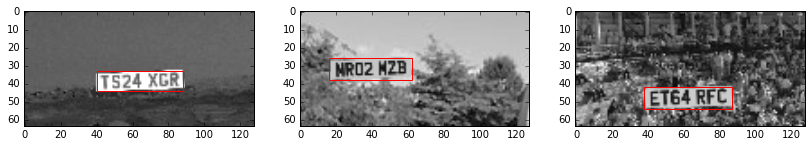

In [30]:
def show_image(sub_plot, image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_random_images(images, labels):
    plt.gray()
    fig = plt.figure()
    n = images.shape[0]
    for i in range(3):
        f = fig.add_subplot(1, 3, i+1)
        index = random.randint(0, n)
        show_image(f, images[index], labels[index])
    plt.show()    
    
plot_random_images(X, Y)    

## Build Tensorflow neural net

### Define loss function

We will optimize mean square error over all predictions.

$$MSE = \frac{1}{n} \sum_{i=1}^{n}{(\hat{y_i} - y_i)^2}$$

In [22]:
def mse(expected, predicted):
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

Test loss function

In [23]:
xs = tf.constant(2, shape=[10, 4])
ys = tf.constant(0, shape=[10, 4])

with tf.Session() as session:
    print(session.run(mse(xs, ys)))

4


## Build simple perception

In [29]:
HIDDEN_1_SIZE = 100
PIXEL_COUNT = X.shape[1] * X.shape[2]
LABEL_COUNT = Y.shape[1]
# Create placeholders for image data and expected point positions
x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])
y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

# Build neural network
def build_model(xs):
    W1 = tf.Variable(tf.truncated_normal([PIXEL_COUNT, HIDDEN_1_SIZE], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[HIDDEN_1_SIZE]))
    hidden1 = tf.nn.relu(tf.matmul(xs, W1) + b1)
    W2 = tf.Variable(tf.truncated_normal([HIDDEN_1_SIZE, LABEL_COUNT], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[LABEL_COUNT]))
    return tf.matmul(hidden1, W2) + b2

# Define loss function
model = build_model(x_placeholder)
loss = mse(y_placeholder, model)

MAX_ITER = 1000
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    X2 = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    for i in range(MAX_ITER):
        train_step.run(feed_dict={x_placeholder: X2, y_placeholder: Y})
        if (i+1) % (MAX_ITER/10) == 0:
            score = loss.eval(feed_dict={x_placeholder: X2, y_placeholder: Y})
            print('Epoch: %d, loss=%f' % (i+1, score))
    Y2 = model.eval(feed_dict={x_placeholder: X2})
Y2  

Epoch: 100, loss=109.521866
Epoch: 200, loss=109.521866
Epoch: 300, loss=109.521866
Epoch: 400, loss=109.521866
Epoch: 500, loss=109.521866
Epoch: 600, loss=109.521866
Epoch: 700, loss=109.521866
Epoch: 800, loss=109.521866
Epoch: 900, loss=109.521866
Epoch: 1000, loss=109.521866


array([[ 40.81799316,  26.16099739,  86.96598816,  37.5269928 ],
       [ 40.81799316,  26.16099739,  86.96598816,  37.5269928 ],
       [ 40.81799316,  26.16099739,  86.96598816,  37.5269928 ],
       ..., 
       [ 40.81799316,  26.16099739,  86.96598816,  37.5269928 ],
       [ 40.81799316,  26.16099739,  86.96598816,  37.5269928 ],
       [ 40.81799316,  26.16099739,  86.96598816,  37.5269928 ]], dtype=float32)

### Show some sample predictions

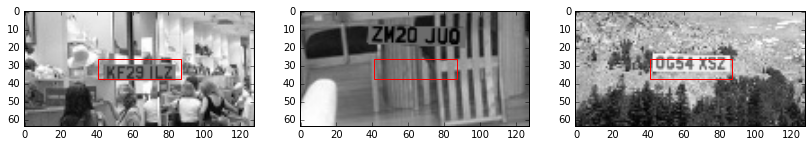

In [31]:
plot_random_images(X, Y2)    